In [1]:
#importing some useful packages
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

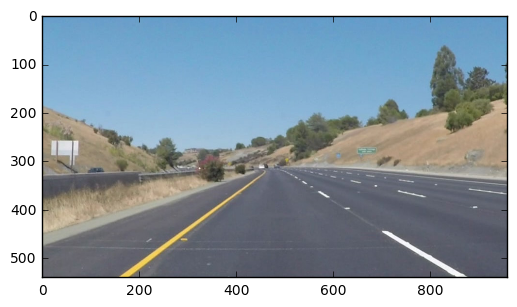

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
plt.imshow(image)

In [41]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    Draws `lines` with `color` and `thickness`.
    
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            slope = float(y2-y1)/(x2-x1)
#             if -0.3 <= slope <=0.3:
            #print(x1, y1, x2, y2, slope)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    height = image.shape[0]
    width = image.shape[1]
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros([img.shape[0], img.shape[1], 3], dtype=np.uint8)

    linesInImage = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = float(y2-y1)/(x2-x1)
            if slope < -0.49:
                x1 = int(x2 + (height-y2)/slope)
                y1 = height
            elif slope > 0.49:
                x2 = int(x1 + (height-y1)/slope)
                y2 = height
            elif -0.1<=slope<=0.1:
                break;
            linesInImage.append([[x1, y1, x2, y2]])
    draw_lines(line_img, linesInImage, thickness=10)
    return line_img
# 183 540 437 342 -0.779527559055
# 701 448 853 540 0.605263157895
# 155 540 396 365 -0.726141078838
# 522 335 877 540 0.577464788732
# 157 540 434 339 -0.725631768953
# 182 540 437 341 -0.780392156863
# 184 540 436 345 -0.77380952381
# 701 447 855 540 0.603896103896
# 538 345 875 540 0.578635014837
# 154 540 362 389 -0.725961538462
# 521 333 878 540 0.579831932773

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, a=0.8, b=1., c=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, a, img, b, c)

In [42]:
def process_image(image):
    imshape = image.shape
    height = image.shape[0]
    width = image.shape[1]
    
    #defining the vertices of the polygon
    vertices = np.array([[(0,imshape[0]),(470, 315), (490, 315), (imshape[1],imshape[0])]], np.int32)
    
    
    gaussBlur = gaussian_noise(image, 3)
    hsv = cv2.cvtColor(gaussBlur, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(hsv, (20, 50, 50), (50, 255, 255))
    white = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))
    gray = cv2.bitwise_or(yellow, white)
    
    low_threshold = 50
    high_threshold = 150
    edges = canny(gray, low_threshold, high_threshold)
    
    # establishing where the polygon is on the image
    roi = region_of_interest(edges, [vertices])
    
    #defining variables for hough lines
    rho = 1
    theta = np.pi/180
    threshold = 40
    min_line_len = 1
    max_line_gap = 200
    lineImage = hough_lines(roi, rho, theta, threshold, min_line_len, max_line_gap)
    result = weighted_img(image, lineImage, 0.8, 0.8)
    return result

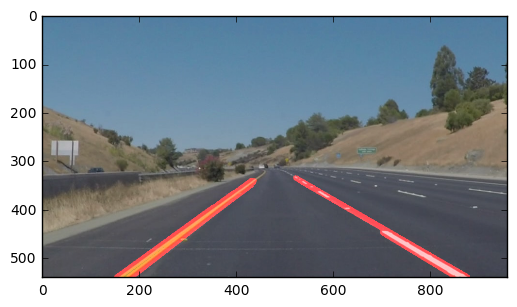

In [43]:
result = process_image(image)
plt.imshow(result)

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [44]:
yellow_output = 'yellow.mp4'
clip1 = VideoFileClip("solidYellowLeft.mp4")
yellow_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4



100%|█████████▉| 681/682 [01:12<00:00,  8.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 20 s, sys: 1.67 s, total: 21.7 s
Wall time: 1min 15s


In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))